In [138]:
def get_hamiltonian(num_cell, v,w):
    L=num_cell
    M=2*L  # number of qubits
    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.

    # sig_X*sig_X operators
    XX = [("XX", [2*i, 2*i + 1], v/2) for i in range(0, L )]  # intra cell
    XX += [("XX", [2*i+1, 2*i + 2], w/2) for i in range(0, L-1 )]  # inter cells

    # replicate for sig_Y*sig_Y
    YY=[ ('YY',)+T[1:] for T in XX]
    #print('XX',XX)
    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*XX,*YY], num_qubits=M)
    return hamiltonian.simplify(),M

In [139]:
# setup 1
ssh_setup={'num_cell':4,'v':0.5, 'w':1.5}
H,M = get_hamiltonian(**ssh_setup)
H

SparsePauliOp(['IIIIIIXX', 'IIIIXXII', 'IIXXIIII', 'XXIIIIII', 'IIIIIXXI', 'IIIXXIII', 'IXXIIIII', 'IIIIIIYY', 'IIIIYYII', 'IIYYIIII', 'YYIIIIII', 'IIIIIYYI', 'IIIYYIII', 'IYYIIIII'],
              coeffs=[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.75+0.j, 0.75+0.j, 0.75+0.j,
 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.75+0.j, 0.75+0.j, 0.75+0.j])

In [140]:
Hinfo={'nq':H.num_qubits, 'size':H.size,'shape':H.to_matrix().shape} 
print(Hinfo)

{'nq': 8, 'size': 14, 'shape': (256, 256)}


In [141]:
def getV(n,i):
    qc=QuantumCircuit(n)
    qc.x(i)
    return Statevector(qc).data

In [142]:
#getV(4,3).T @ H.to_matrix() @ getV(4,3)

In [143]:
# Matrix elements of transitions between binary states
Htran=np.zeros((M,M),dtype=np.complex64)
for i in range(M):
    for j in range(M):
        Htran[i,j]=getV(M,i).T @ H.to_matrix() @ getV(M,j)

for i in range(M):
    print('row:',i,Htran[i])
        #print(i,j,)
    

row: 0 [0. +0.j 0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
row: 1 [0.5+0.j 0. +0.j 1.5+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
row: 2 [0. +0.j 1.5+0.j 0. +0.j 0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
row: 3 [0. +0.j 0. +0.j 0.5+0.j 0. +0.j 1.5+0.j 0. +0.j 0. +0.j 0. +0.j]
row: 4 [0. +0.j 0. +0.j 0. +0.j 1.5+0.j 0. +0.j 0.5+0.j 0. +0.j 0. +0.j]
row: 5 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j 0. +0.j 1.5+0.j 0. +0.j]
row: 6 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 1.5+0.j 0. +0.j 0.5+0.j]
row: 7 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j 0. +0.j]


### Product formula overview

If it isn't specified, the default product formula that `TrotterQRTE` uses is the Lie product formula [2], which is at first order. In Qiskit this is implemented in the [LieTrotter](https://docs.quantum.ibm.com/api/qiskit/qiskit.synthesis.LieTrotter) class. A first order formula consists of the approximation stated in the introduction, where the matrix exponential of a sum is approximated by a product of matrix exponentials:

$$
e^{A+B} \approx e^A e^B
$$


Trotter step with Lie-Trotter
-----------------------------
            Hamiltonian:{'nq': 8, 'size': 14, 'shape': (256, 256)}
                  Depth: 20
             Gate count: 98
    Nonlocal gate count: 28
         Gate breakdown: H: 28, CX: 28, RX: 28, RZ: 14



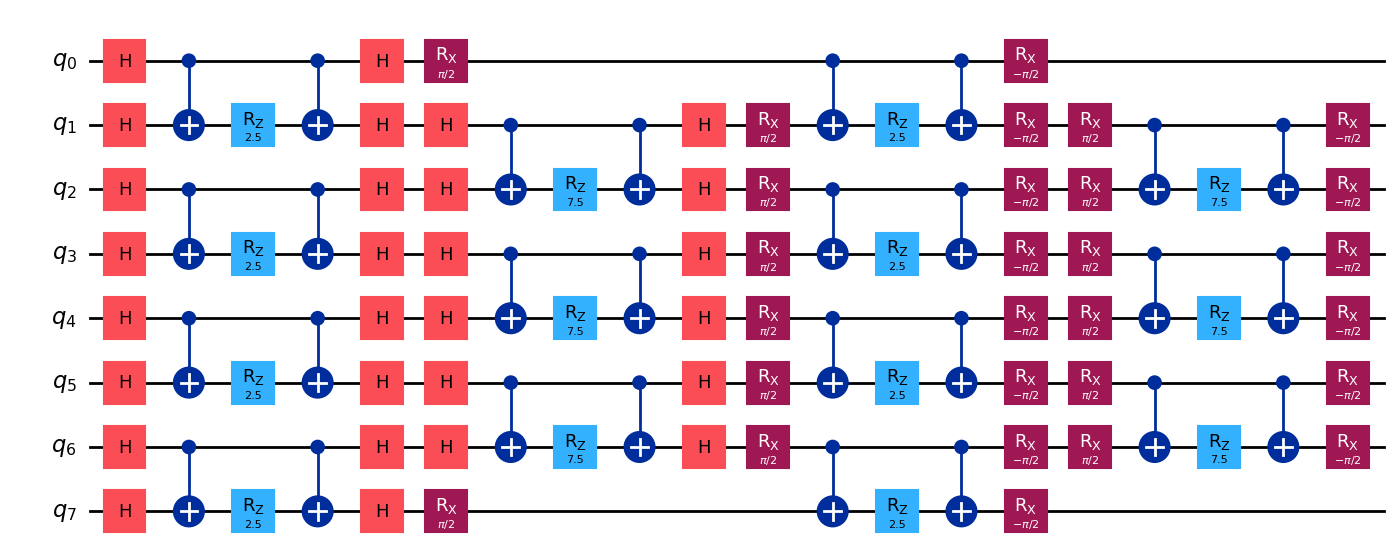

In [144]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
num_timesteps=3
final_time= 15
dt = final_time / num_timesteps
trotter_step_first_order = PauliEvolutionGate(H, dt, synthesis=LieTrotter())

# We create an empty circuit
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_first_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(
    f"""
Trotter step with Lie-Trotter
-----------------------------
            Hamiltonian:{Hinfo}
                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}
"""
)

# And finally draw the circuit
circuit.draw("mpl")

There exists a second-order formula, called the Suzuki-Trotter decomposition [3], and can be used in Qiskit by means of the [SuzukiTrotter class](https://docs.quantum.ibm.com/api/qiskit/qiskit.synthesis.SuzukiTrotter). Using this formula, a second order decomposition is:

$$
e^{A+B} \approx e^{B/2}e^{A}e^{B/2}
$$

By means of recursions, higher-order approximations can be found [1].


Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: 40
             Gate count: 189
    Nonlocal gate count: 54
         Gate breakdown: H: 56, CX: 54, RX: 52, RZ: 27




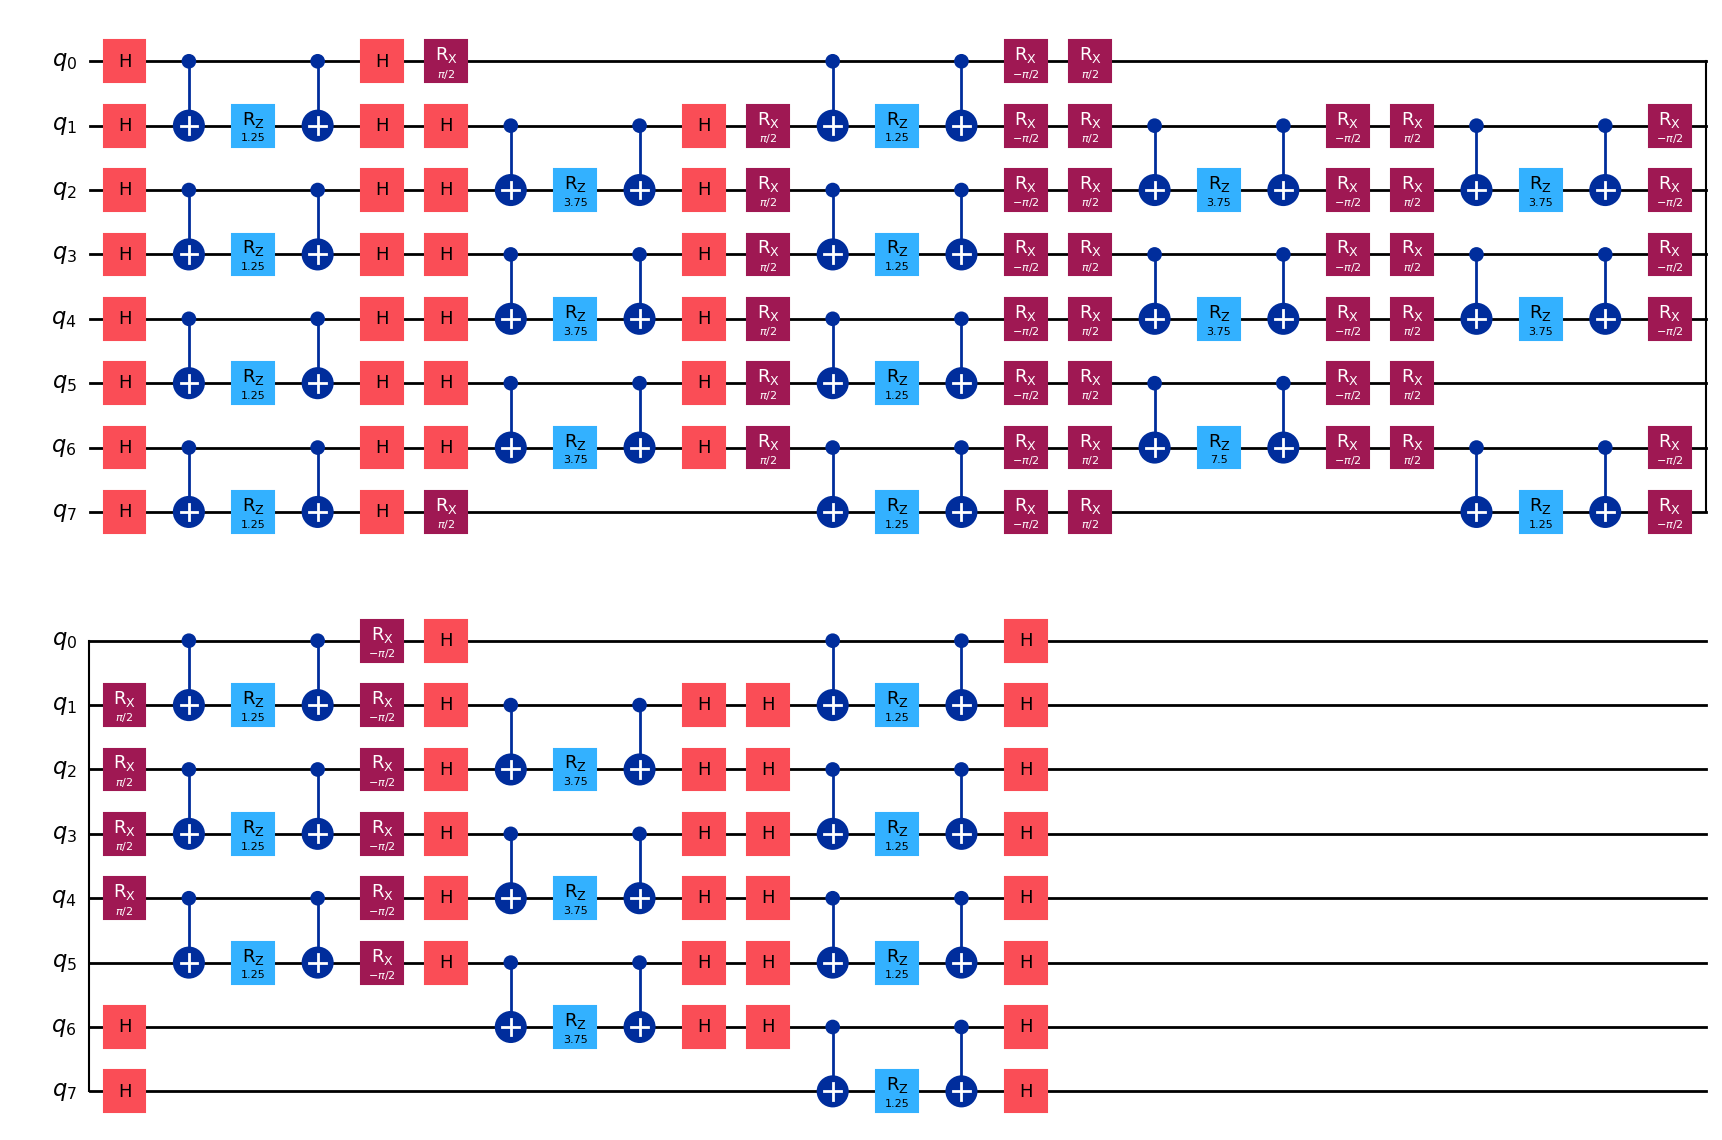

In [145]:
from qiskit.synthesis import SuzukiTrotter

second_order_formula = SuzukiTrotter()  # if not passed, order defaults to 2
trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_second_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(
    f"""
Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)

# And finall
circuit.draw("mpl")